## Rete dei Collaborazione tra Giocatori 

Nodi: Giocatori

Archi: Partite giocate insieme

Peso degli archi: Numero di partite condivise

Analisi:

- Identificare gruppi di giocatori che giocano spesso insieme
- Analizzare la coesione delle squadre
- Studiare l'evoluzione delle formazioni nel tempo

In [51]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import community
import numpy as np
from tqdm import tqdm

# Carica i dati
games_df = pd.read_csv('../Datasets/SNA/games.csv')
players_df = pd.read_csv('../Datasets/SNA/players.csv')

print(f"Partite caricate: {len(games_df)}")
print(f"Giocatori caricati: {len(players_df)}")

Partite caricate: 72241
Giocatori caricati: 32426


In [52]:
def create_player_collaboration_network(games_df, players_df, season=2013):
    """
    Crea una rete di collaborazione arricchita con informazioni sui giocatori.
    """
    print(f"\nAnalisi della stagione {season}...")
    
    # Filtriamo per stagione
    season_games = games_df[games_df['season'] == season]
    
    # Struttura dati per le collaborazioni
    collaborations = defaultdict(lambda: {
        'matches': set(),
        'formations': [],
        'competitions': set(),
        'home_goals': 0,
        'away_goals': 0
    })
    
    # Tracciamo statistiche per squadra
    team_stats = defaultdict(lambda: {
        'matches': 0,
        'goals_scored': 0,
        'goals_conceded': 0,
        'formations': set()
    })
    
    for _, game in tqdm(season_games.iterrows(), desc="Analizzando partite"):
        home_id = game['home_club_id']
        away_id = game['away_club_id']
        
        # Aggiorniamo statistiche squadre
        team_stats[home_id]['matches'] += 1
        team_stats[away_id]['matches'] += 1
        team_stats[home_id]['goals_scored'] += game['home_club_goals']
        team_stats[away_id]['goals_scored'] += game['away_club_goals']
        team_stats[home_id]['goals_conceded'] += game['away_club_goals']
        team_stats[away_id]['goals_conceded'] += game['home_club_goals']
        
        if isinstance(game['home_club_formation'], str):
            team_stats[home_id]['formations'].add(game['home_club_formation'])
        if isinstance(game['away_club_formation'], str):
            team_stats[away_id]['formations'].add(game['away_club_formation'])
        
        # Creiamo le collaborazioni
        home_players = [f"player_{home_id}_{i}" for i in range(11)]
        away_players = [f"player_{away_id}_{i}" for i in range(11)]
        
        # Collaborazioni squadra casa
        for i, p1 in enumerate(home_players):
            for p2 in home_players[i+1:]:
                key = tuple(sorted([p1, p2]))
                collaborations[key]['matches'].add(game['game_id'])
                collaborations[key]['formations'].append(game['home_club_formation'])
                collaborations[key]['competitions'].add(game['competition_type'])
                collaborations[key]['home_goals'] += game['home_club_goals']
                
        # Collaborazioni squadra trasferta
        for i, p1 in enumerate(away_players):
            for p2 in away_players[i+1:]:
                key = tuple(sorted([p1, p2]))
                collaborations[key]['matches'].add(game['game_id'])
                collaborations[key]['formations'].append(game['away_club_formation'])
                collaborations[key]['competitions'].add(game['competition_type'])
                collaborations[key]['away_goals'] += game['away_club_goals']
    
    return collaborations, team_stats

In [53]:
def build_network(collaborations, min_matches=3):
    """
    Costruisce il grafo con metriche arricchite.
    """
    print(f"\nCostruzione della rete (min partite: {min_matches})...")
    
    G = nx.Graph()
    
    for (p1, p2), data in collaborations.items():
        if len(data['matches']) >= min_matches:
            G.add_edge(p1, p2,
                      weight=len(data['matches']),
                      formations=list(set(data['formations'])),
                      competitions=list(data['competitions']),
                      goals_scored=data['home_goals'] + data['away_goals'])
    
    print(f"Rete creata con {G.number_of_nodes()} nodi e {G.number_of_edges()} archi")
    return G


In [54]:
def analyze_network(G, team_stats):
    """
    Analisi approfondita della rete e delle squadre, gestendo grafi non connessi.
    """
    print("\nAnalisi della rete...")
    
    # Metriche base
    print("\nMetriche di base:")
    print(f"Densità: {nx.density(G):.4f}")
    
    # Analisi delle componenti connesse
    components = list(nx.connected_components(G))
    print(f"Numero di componenti connesse: {len(components)}")
    
    # Analisi della componente gigante
    giant = G.subgraph(max(components, key=len))
    print(f"Dimensione della componente gigante: {giant.number_of_nodes()} nodi")
    print(f"Percentuale della rete nella componente gigante: {giant.number_of_nodes()/G.number_of_nodes()*100:.1f}%")
    
    # Metriche della componente gigante
    print("\nMetriche della componente gigante:")
    print(f"Diametro: {nx.diameter(giant)}")
    print(f"Raggio: {nx.radius(giant)}")
    print(f"Coefficiente di clustering medio: {nx.average_clustering(giant):.4f}")
    
    # Analisi delle comunità nella componente gigante
    communities = community.best_partition(giant)
    modularity = community.modularity(communities, giant)
    print(f"\nComunità rilevate nella componente gigante: {len(set(communities.values()))}")
    print(f"Modularità: {modularity:.4f}")
    
    # Analisi delle formazioni più utilizzate
    formation_counts = defaultdict(int)
    for _, _, data in G.edges(data=True):
        for formation in data['formations']:
            if isinstance(formation, str):
                formation_counts[formation] += 1
    
    print("\nFormazioni più utilizzate:")
    for formation, count in sorted(formation_counts.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"{formation}: {count} volte")
    
    # Analisi della centralità
    print("\nGiocatori più centrali (per grado):")
    degree_cent = nx.degree_centrality(giant)
    top_players = sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:5]
    for player, centrality in top_players:
        print(f"Giocatore {player}: {centrality:.4f}")
    
    return communities, giant

In [55]:
def visualize_analysis(G, communities, giant, team_stats):
    """
    Visualizzazioni multiple dell'analisi.
    """
    # 1. Rete di collaborazione (componente gigante)
    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(giant)
    
    nx.draw(giant, pos,
            node_color=[communities.get(node, 0) for node in giant.nodes()],
            node_size=[giant.degree(node) * 20 for node in giant.nodes()],
            edge_color=[giant[u][v]['weight'] for u, v in giant.edges()],
            edge_cmap=plt.cm.YlOrRd,
            with_labels=False)
    
    plt.title("Rete di Collaborazione tra Giocatori (Componente Gigante)")
    plt.show()
    
    # 2. Distribuzione dei gradi
    plt.figure(figsize=(10, 6))
    degrees = [d for n, d in giant.degree()]
    plt.hist(degrees, bins=30, alpha=0.75)
    plt.title("Distribuzione dei Gradi nella Componente Gigante")
    plt.xlabel("Grado")
    plt.ylabel("Frequenza")
    plt.show()
    
    # 3. Distribuzione delle collaborazioni
    plt.figure(figsize=(10, 6))
    weights = [d['weight'] for _, _, d in giant.edges(data=True)]
    plt.hist(weights, bins=30, alpha=0.75)
    plt.title("Distribuzione del Numero di Collaborazioni")
    plt.xlabel("Partite giocate insieme")
    plt.ylabel("Frequenza")
    plt.show()
    
    # 4. Statistiche delle squadre
    team_df = pd.DataFrame.from_dict(team_stats, orient='index')
    plt.figure(figsize=(12, 6))
    team_df['goals_scored'].plot(kind='bar')
    plt.title("Gol Segnati per Squadra")
    plt.xticks(rotation=45)
    plt.show()

In [56]:
print("Prime righe del dataset:")
print(games_df.head())

Prime righe del dataset:
   game_id competition_id  season        round        date  home_club_id  \
0  2321027             L1    2013  1. Matchday  2013-08-11          33.0   
1  2321033             L1    2013  1. Matchday  2013-08-10          23.0   
2  2321044             L1    2013  2. Matchday  2013-08-18          16.0   
3  2321060             L1    2013  3. Matchday  2013-08-25          23.0   
4  2321072             L1    2013  5. Matchday  2013-09-14          16.0   

   away_club_id  home_club_goals  away_club_goals  home_club_position  ...  \
0          41.0              3.0              3.0                 8.0  ...   
1          86.0              0.0              1.0                13.0  ...   
2          23.0              2.0              1.0                 1.0  ...   
3          24.0              0.0              2.0                18.0  ...   
4          41.0              6.0              2.0                 1.0  ...   

             stadium attendance         referee  

In [57]:
# Informazioni sulle colonne
print("\nInformazioni sulle colonne:")
print(games_df.info())


Informazioni sulle colonne:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72241 entries, 0 to 72240
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   game_id                 72241 non-null  int64  
 1   competition_id          72241 non-null  object 
 2   season                  72241 non-null  int64  
 3   round                   72241 non-null  object 
 4   date                    72241 non-null  object 
 5   home_club_id            72232 non-null  float64
 6   away_club_id            72232 non-null  float64
 7   home_club_goals         72229 non-null  float64
 8   away_club_goals         72229 non-null  float64
 9   home_club_position      50143 non-null  float64
 10  away_club_position      50143 non-null  float64
 11  home_club_manager_name  71414 non-null  object 
 12  away_club_manager_name  71414 non-null  object 
 13  stadium                 71991 non-null  object 
 14  attendanc

In [58]:
print("Prime righe del dataset:")
print(players_df.head())

Prime righe del dataset:
   player_id first_name     last_name                name  last_season  \
0         10   Miroslav         Klose      Miroslav Klose         2015   
1         26      Roman  Weidenfeller  Roman Weidenfeller         2017   
2         65    Dimitar      Berbatov    Dimitar Berbatov         2015   
3         77        NaN         Lúcio               Lúcio         2012   
4         80        Tom        Starke          Tom Starke         2017   

   current_club_id         player_code    country_of_birth city_of_birth  \
0              398      miroslav-klose              Poland         Opole   
1               16  roman-weidenfeller             Germany          Diez   
2             1091    dimitar-berbatov            Bulgaria   Blagoevgrad   
3              506               lucio              Brazil      Brasília   
4               27          tom-starke  East Germany (GDR)       Freital   

  country_of_citizenship  ...   foot height_in_cm contract_expiration_dat

In [59]:
print("Prime righe del dataset:")
print(players_df.head())

Prime righe del dataset:
   player_id first_name     last_name                name  last_season  \
0         10   Miroslav         Klose      Miroslav Klose         2015   
1         26      Roman  Weidenfeller  Roman Weidenfeller         2017   
2         65    Dimitar      Berbatov    Dimitar Berbatov         2015   
3         77        NaN         Lúcio               Lúcio         2012   
4         80        Tom        Starke          Tom Starke         2017   

   current_club_id         player_code    country_of_birth city_of_birth  \
0              398      miroslav-klose              Poland         Opole   
1               16  roman-weidenfeller             Germany          Diez   
2             1091    dimitar-berbatov            Bulgaria   Blagoevgrad   
3              506               lucio              Brazil      Brasília   
4               27          tom-starke  East Germany (GDR)       Freital   

  country_of_citizenship  ...   foot height_in_cm contract_expiration_dat

In [60]:
# Esecuzione dell'analisi
collaborations, team_stats = create_player_collaboration_network(games_df, players_df)


Analisi della stagione 2013...


Analizzando partite: 5762it [00:02, 2097.20it/s]


In [61]:
G = build_network(collaborations)


Costruzione della rete (min partite: 3)...
Rete creata con 5489 nodi e 27445 archi


In [62]:
communities, giant = analyze_network(G, team_stats)


Analisi della rete...

Metriche di base:
Densità: 0.0018
Numero di componenti connesse: 499
Dimensione della componente gigante: 11 nodi
Percentuale della rete nella componente gigante: 0.2%

Metriche della componente gigante:
Diametro: 1
Raggio: 1
Coefficiente di clustering medio: 1.0000

Comunità rilevate nella componente gigante: 1
Modularità: 0.0000

Formazioni più utilizzate:
4-2-3-1: 19305 volte
4-4-2 double 6: 11660 volte
4-3-3 Attacking: 11220 volte
4-4-2: 9955 volte
4-1-4-1: 8250 volte

Giocatori più centrali (per grado):
Giocatore player_33.0_7: 1.0000
Giocatore player_33.0_9: 1.0000
Giocatore player_33.0_6: 1.0000
Giocatore player_33.0_5: 1.0000
Giocatore player_33.0_3: 1.0000


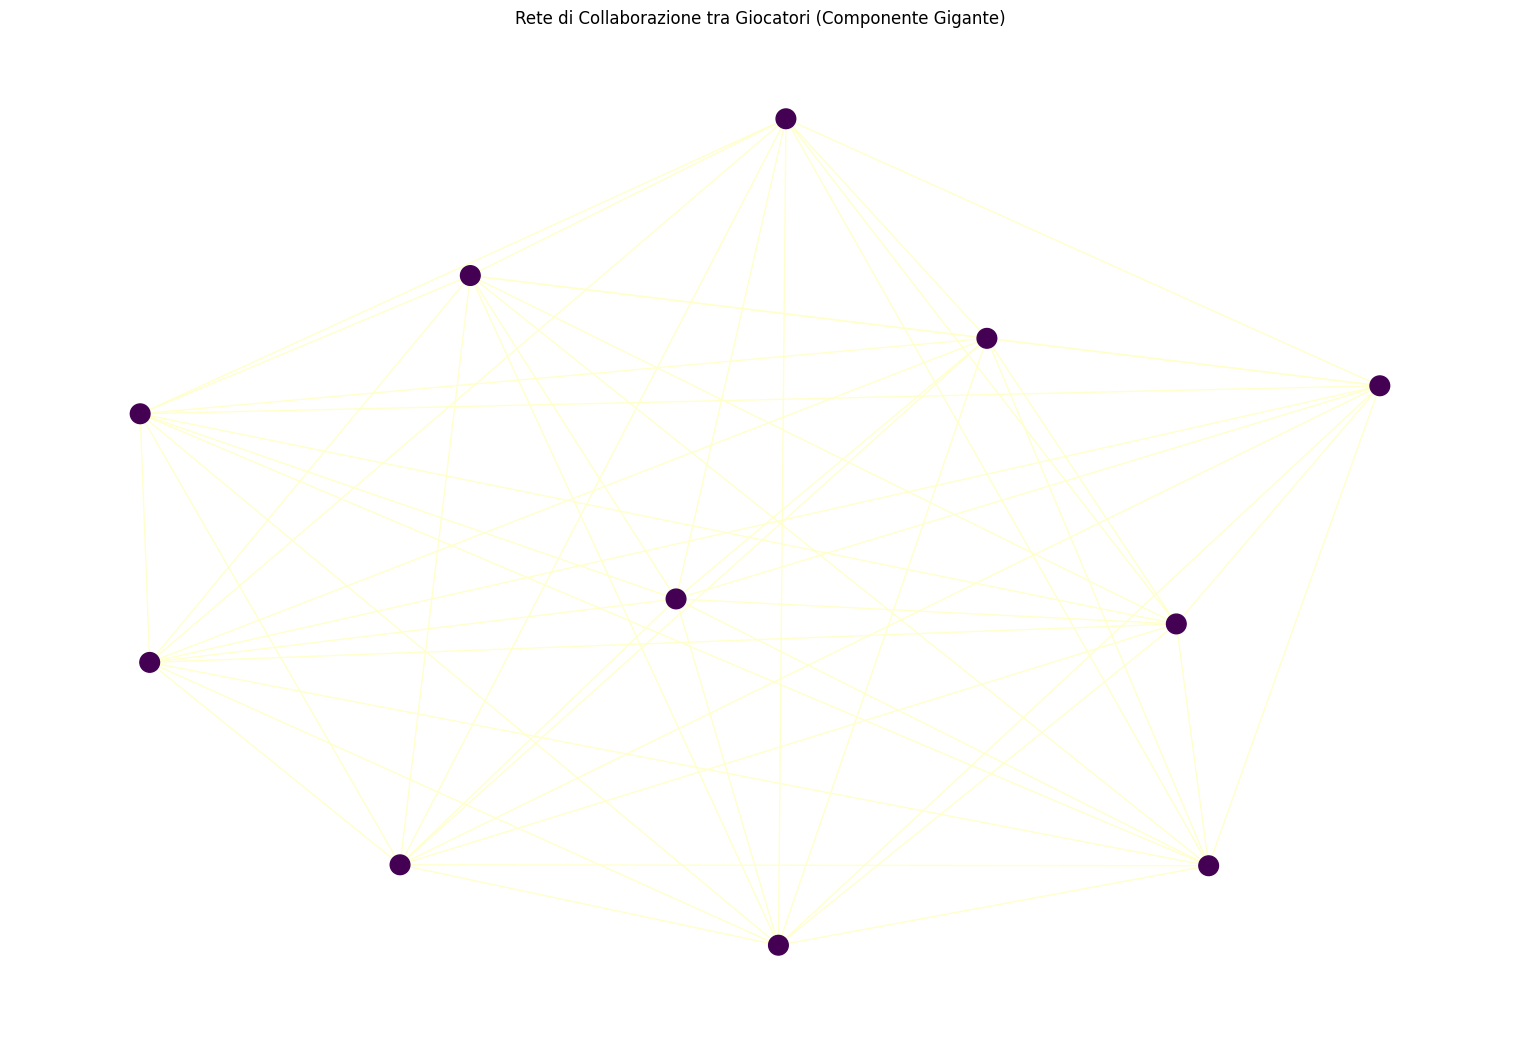

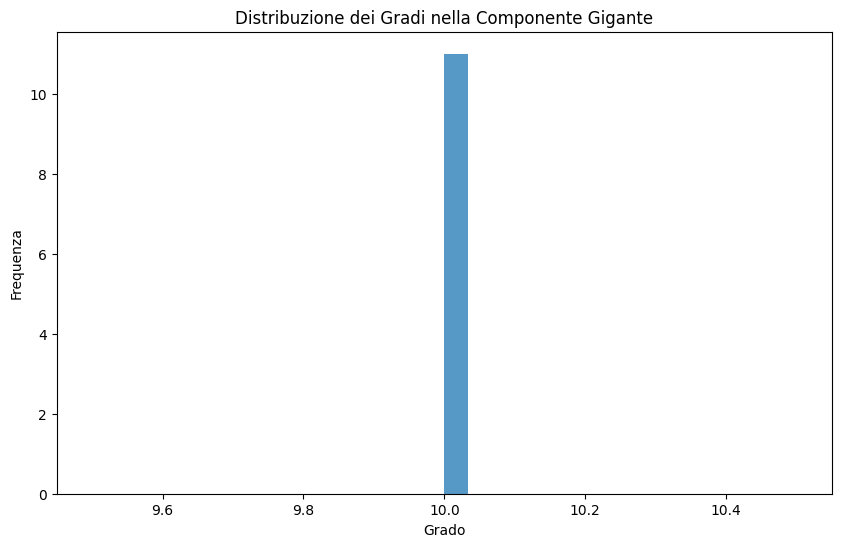

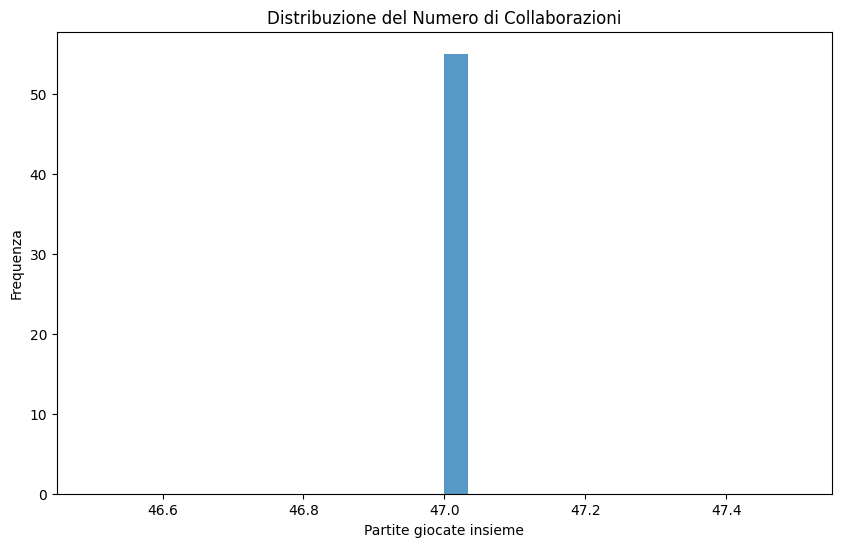

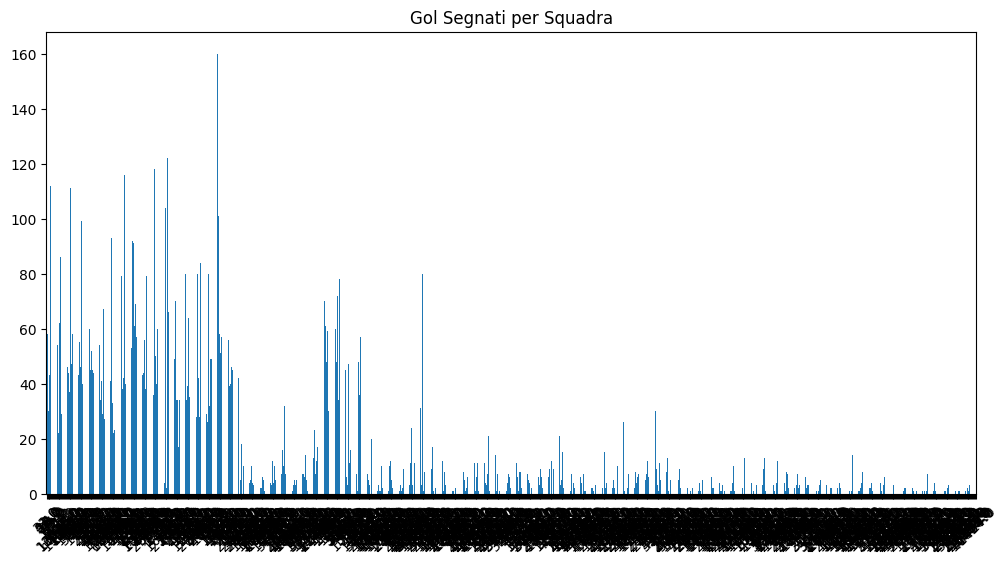

In [63]:
visualize_analysis(G, communities, giant, team_stats)